In [1]:
import pandas as pd
import numpy as np
import patsy
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import rgb2hex
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [2]:
df = pd.read_csv('dataset.csv')
X = df.drop(columns=['Activity'])
y = df['Activity']

dcopy = df.copy()
dcopy['Activity'] = [
    1 if a == 'WALKING'
    else 2 if a == 'WALKING_UPSTAIRS'
    else 3 if a == 'WALKING_DOWNSTAIRS'
    else 4 if a == 'SITTING'
    else 5 if a == 'STANDING'
    else 6 if a == 'LAYING'
    else 7 if a == 'STAND_TO_SIT'
    else 8 if a == 'SIT_TO_STAND'
    else 9 if a == 'SIT_TO_LIE'
    else 10 if a == 'LIE_TO_SIT'
    else 11 if a == 'STAND_TO_LIE'
    else 12
    for a in dcopy['Activity']
]

In [3]:
na = df.isna().any()
na[na == True]

Series([], dtype: bool)

## Distribuição de classes

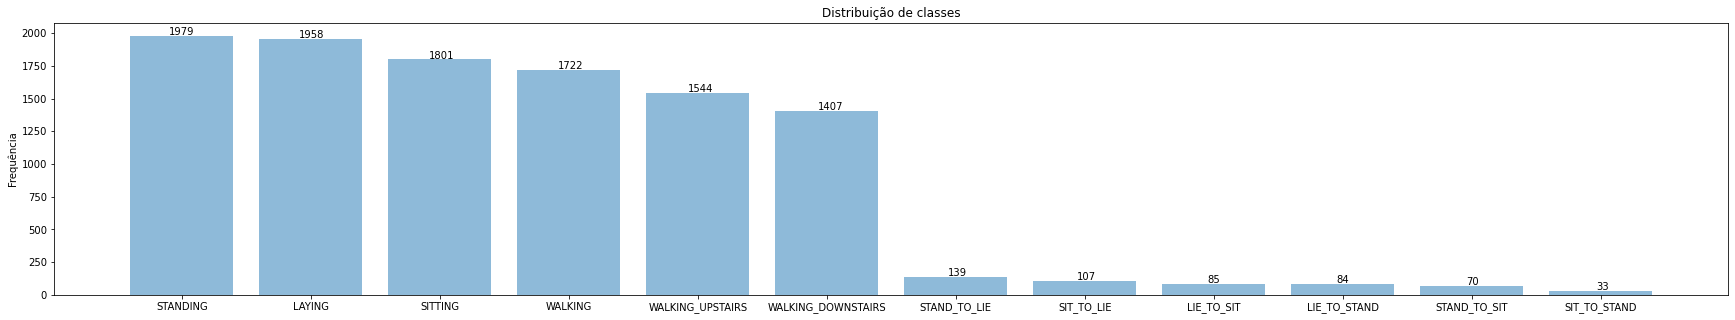

In [4]:
counts = y.value_counts()
bar_y = counts.index.to_list()
bar_x = counts.tolist()
y_pos = np.arange(len(bar_y))

plt.subplots(figsize=(30,5))
plt.bar(y_pos, bar_x, align='center', alpha = 0.5)
plt.xticks(y_pos, bar_y)
xlocs, xlabs = plt.xticks()
plt.ylabel('Frequência')
plt.title('Distribuição de classes')
for i, v in enumerate(bar_x):
    plt.text(xlocs[i] - 0.1 + i*0.006, v + 5, str(v))

## Boxplot

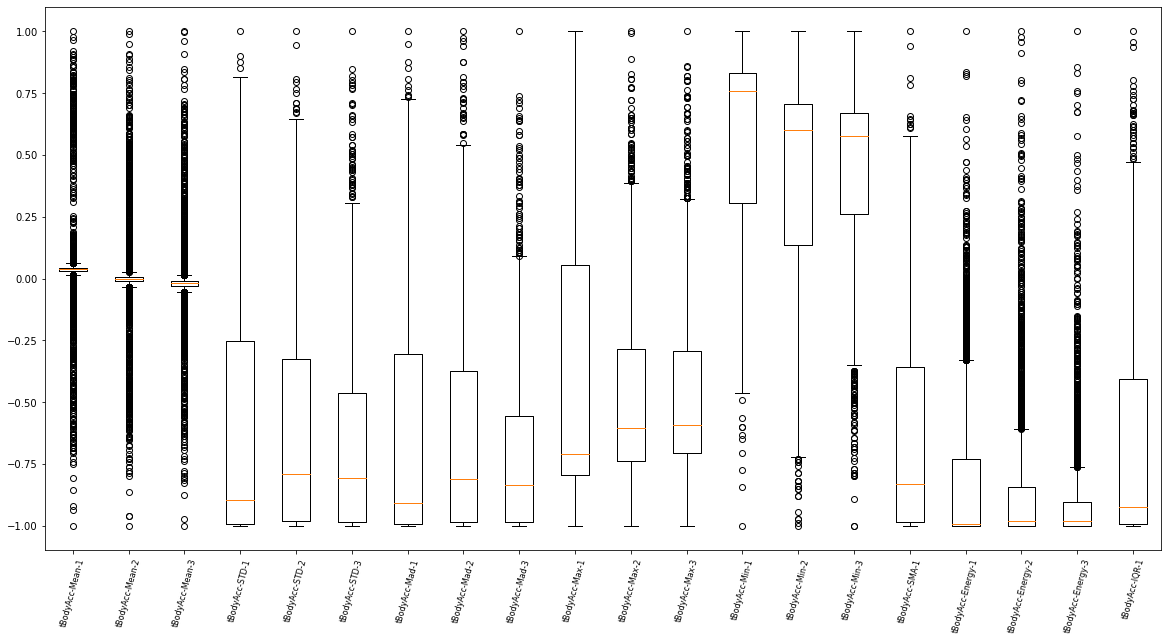

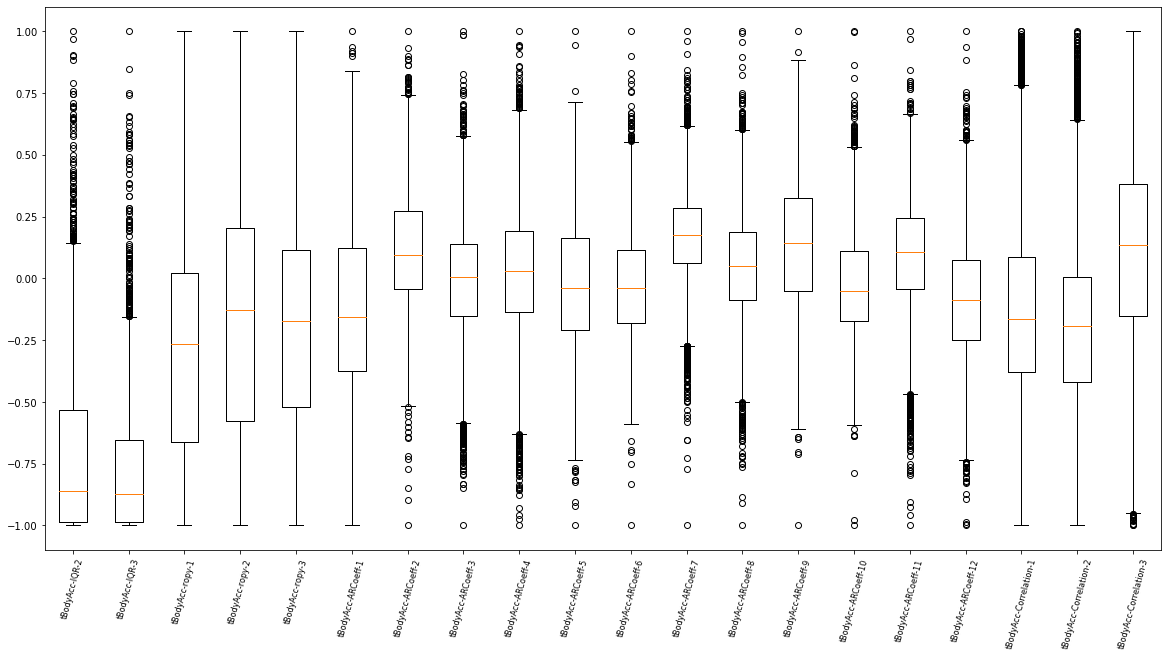

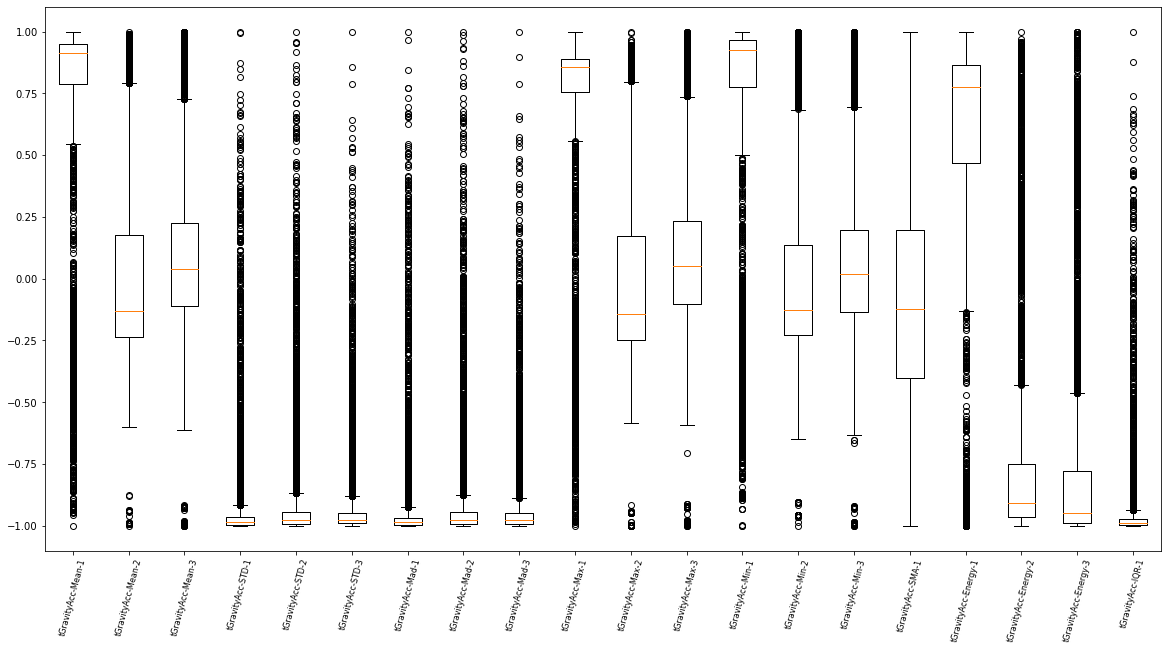

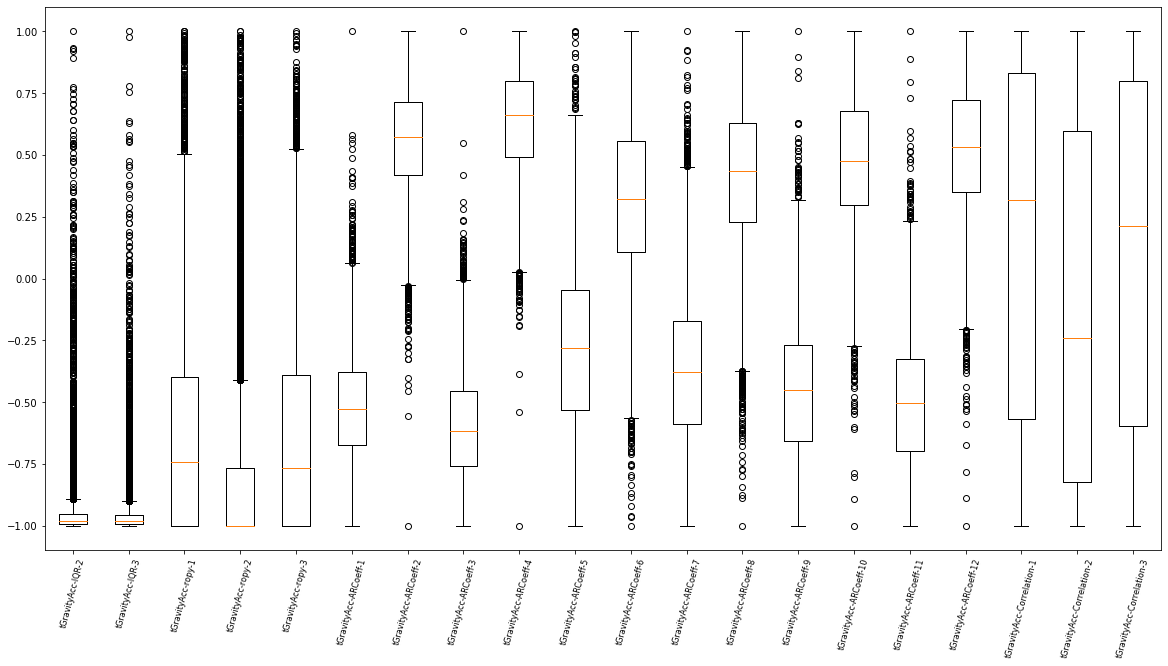

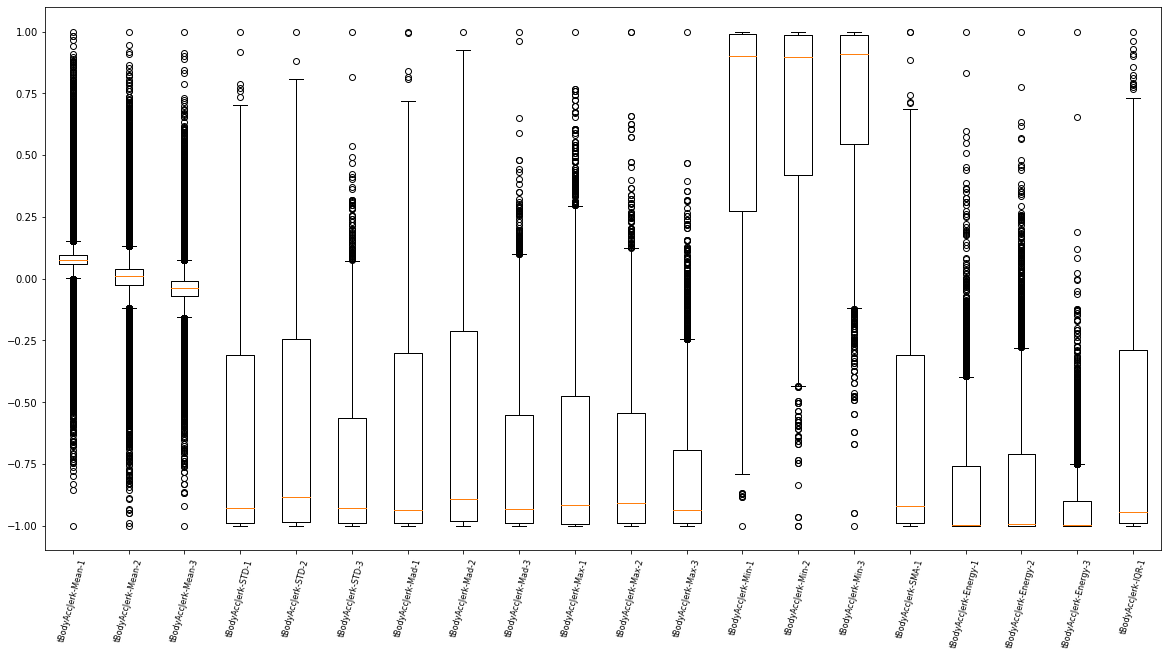

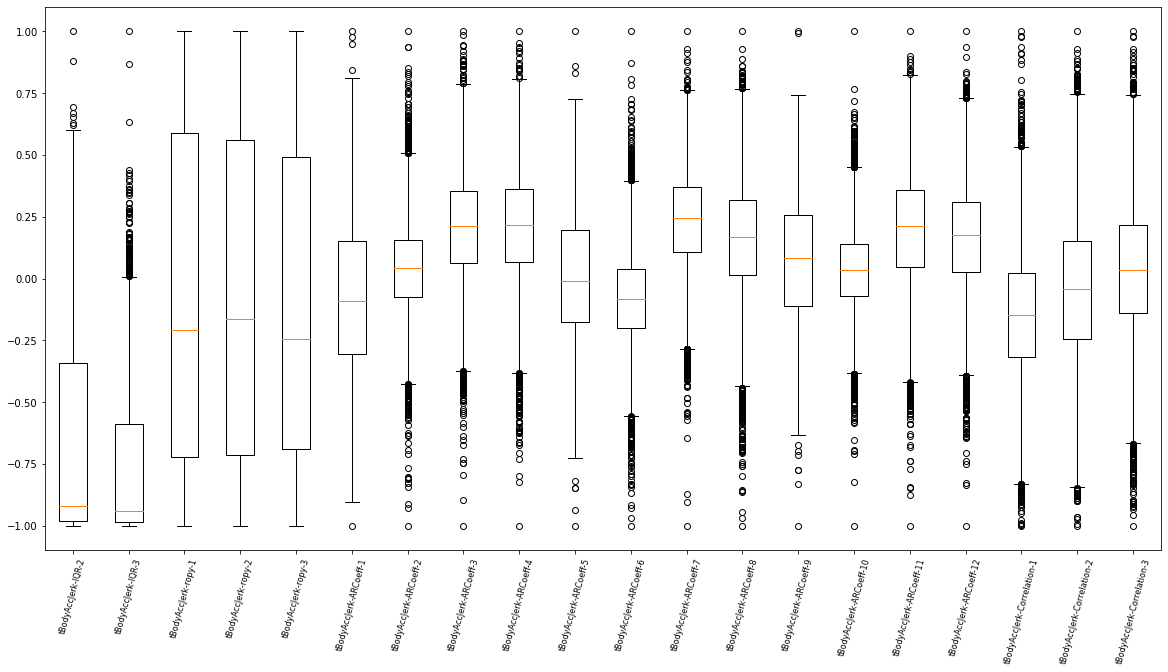

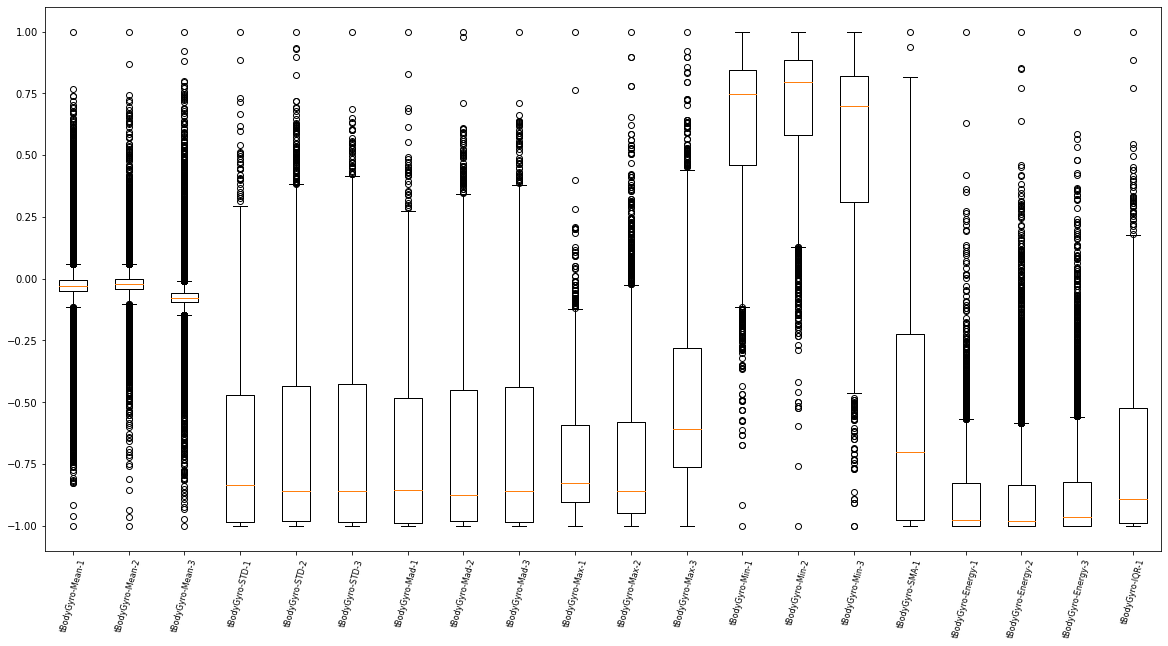

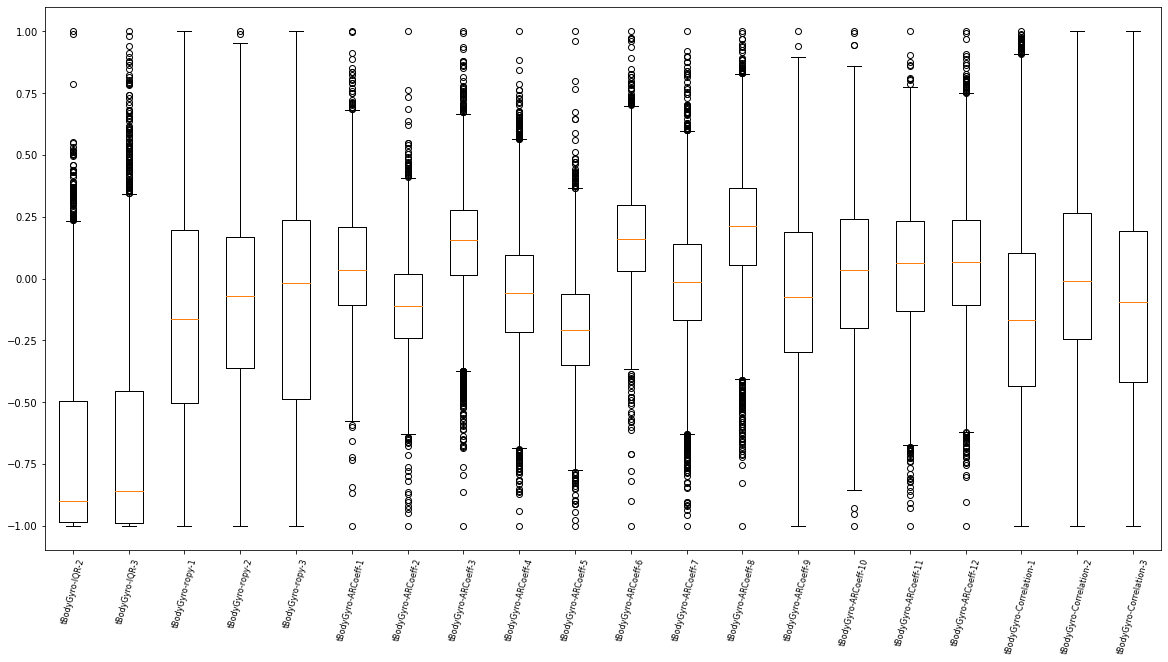

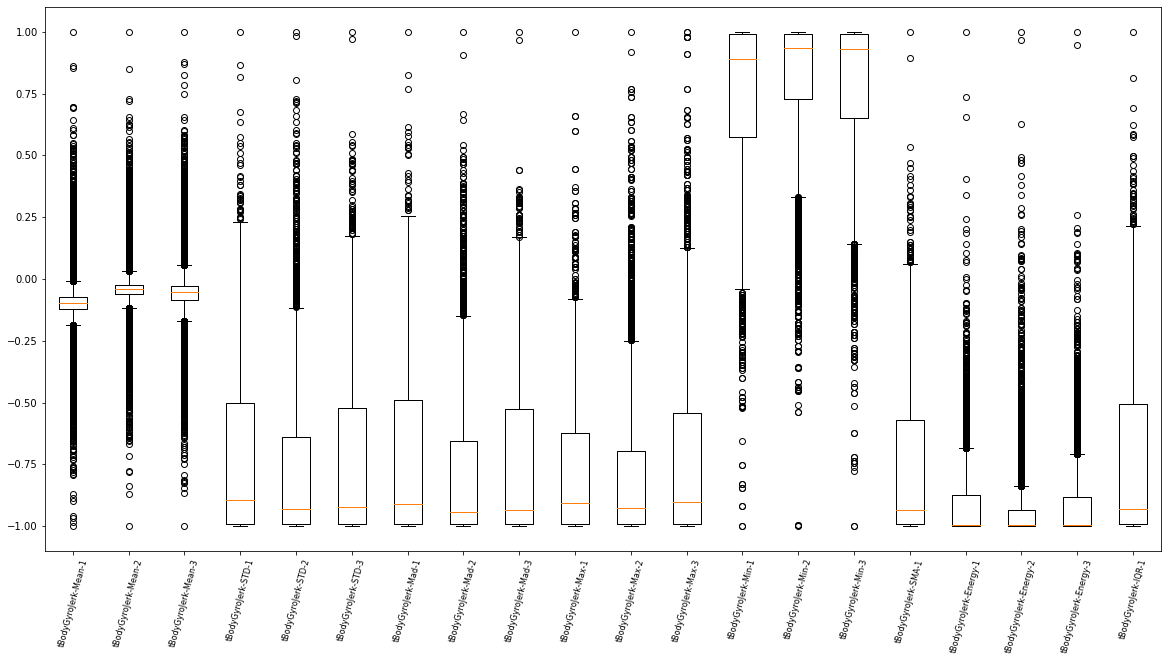

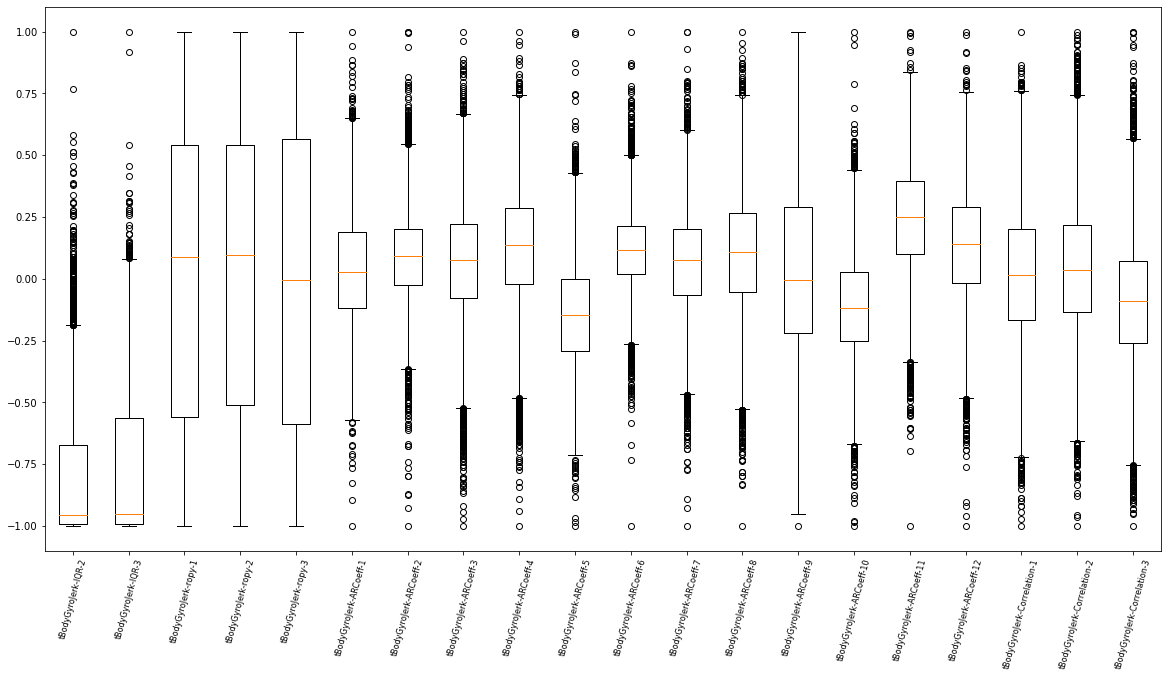

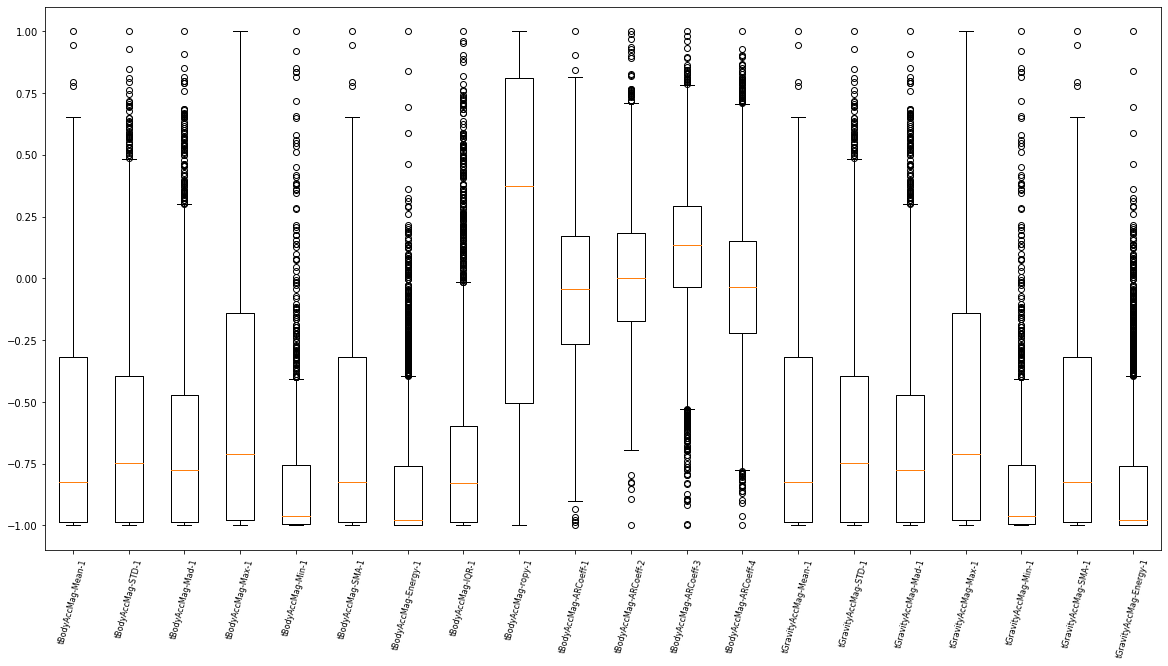

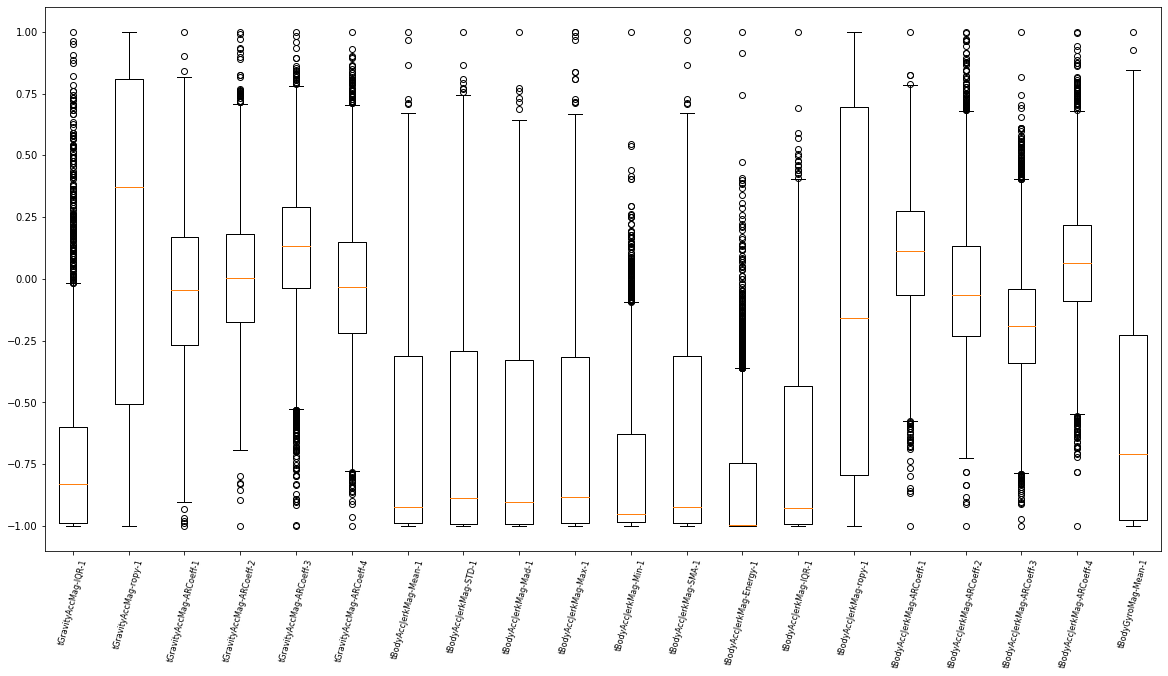

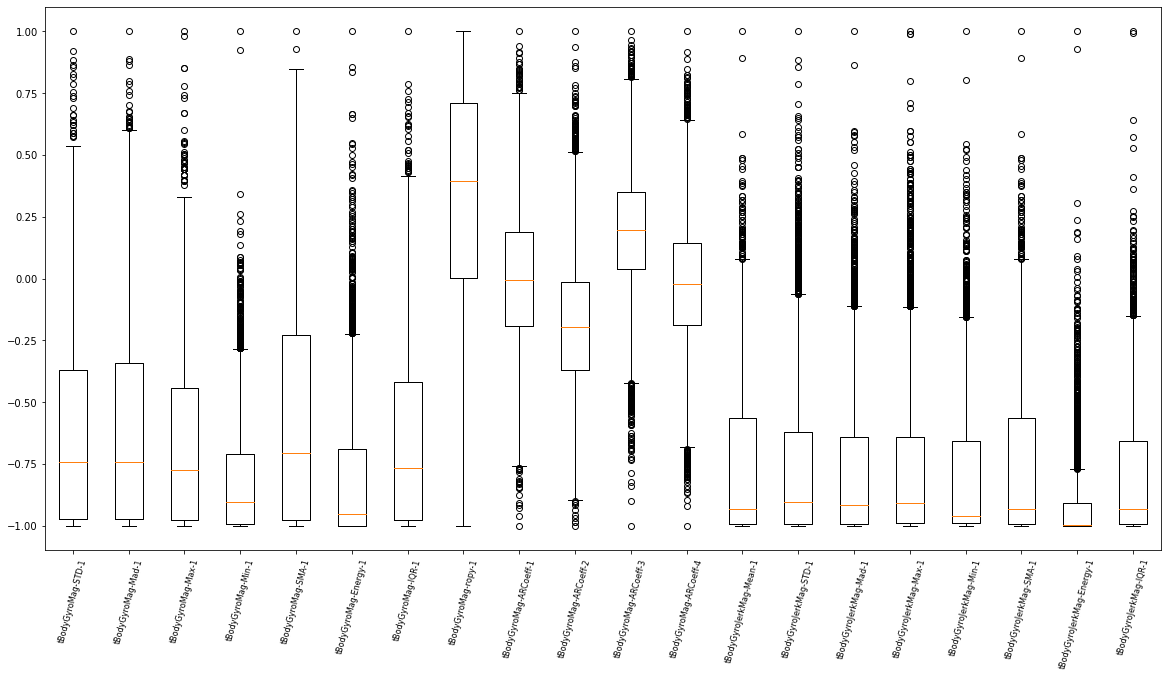

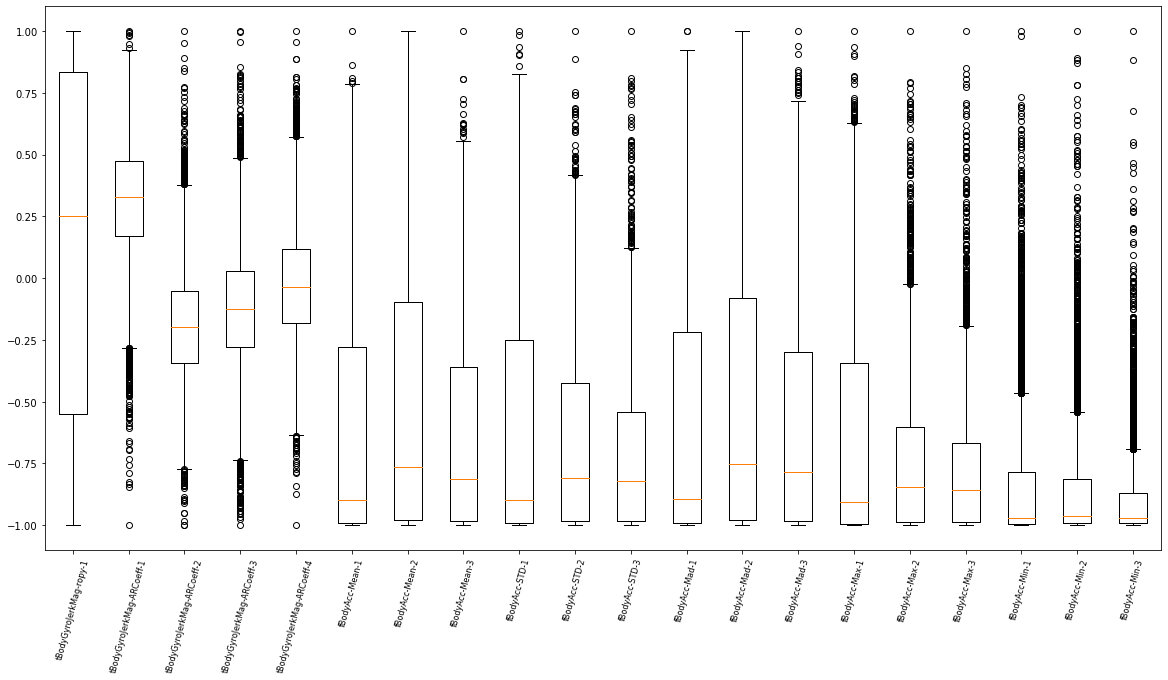

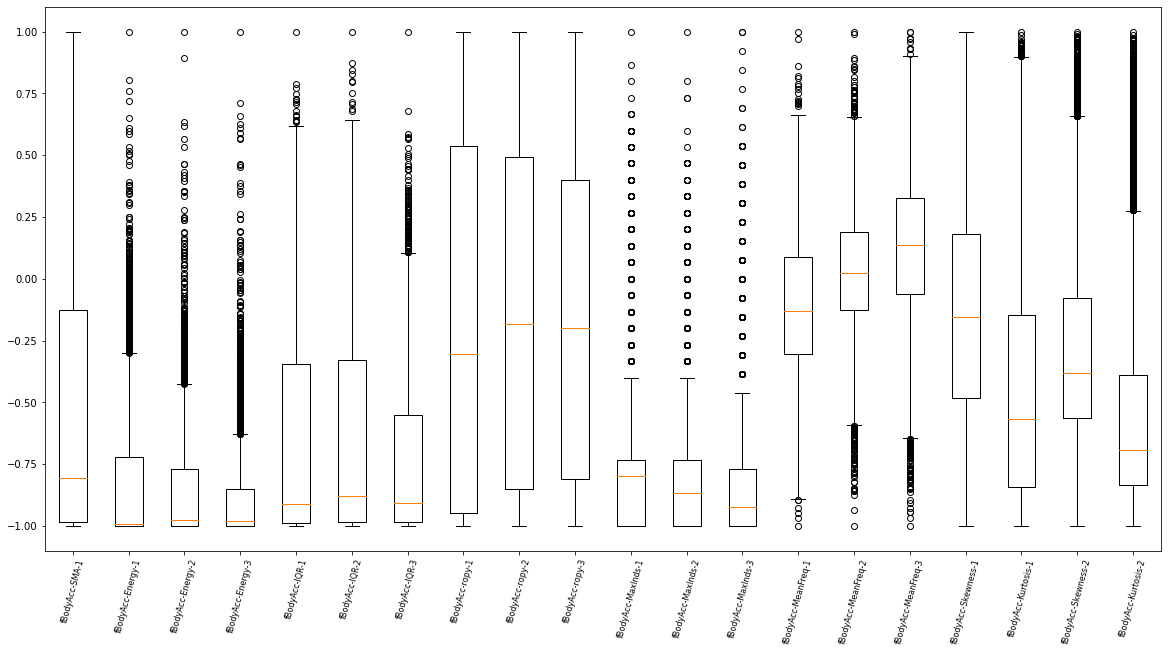

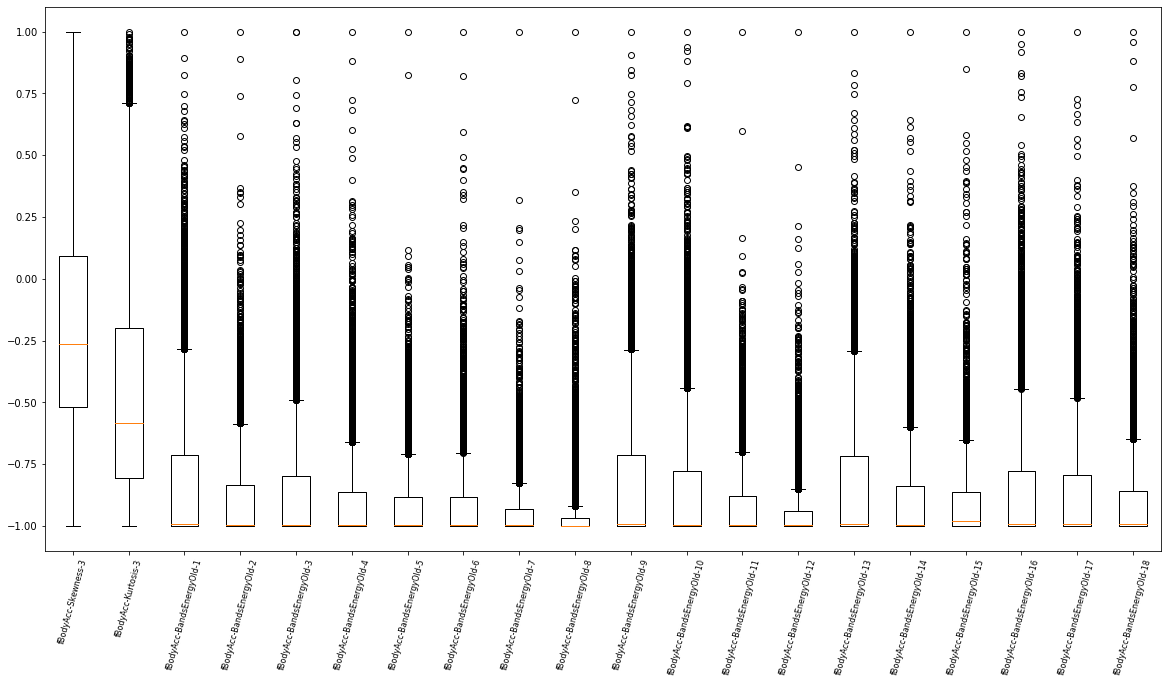

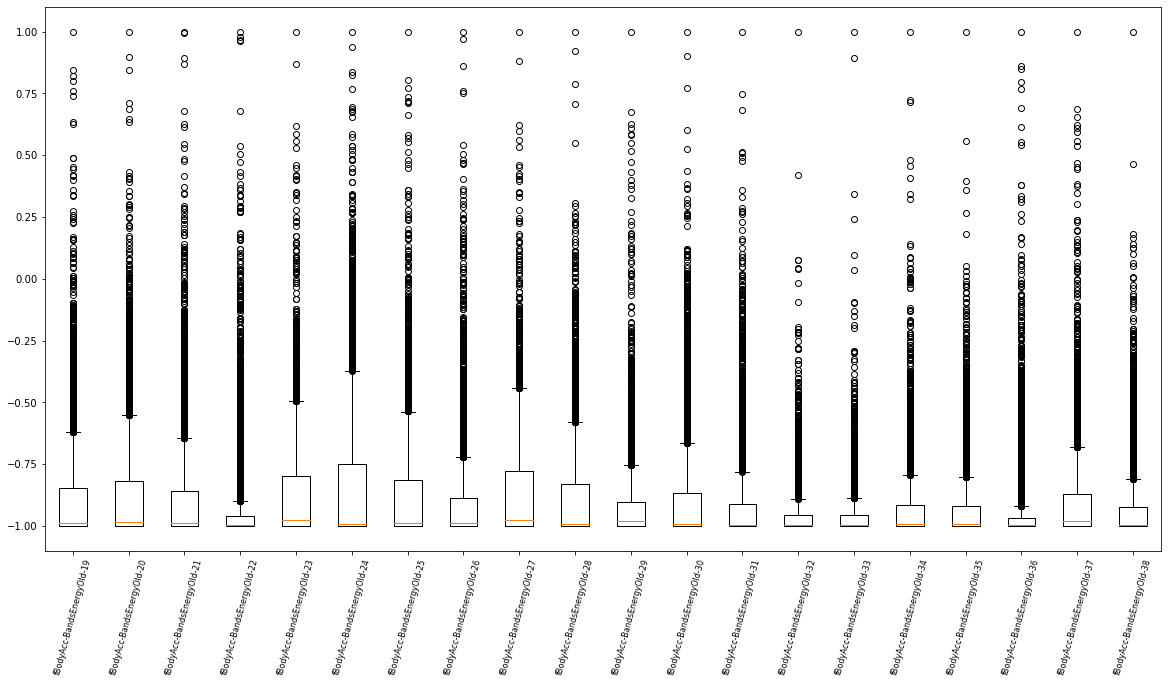

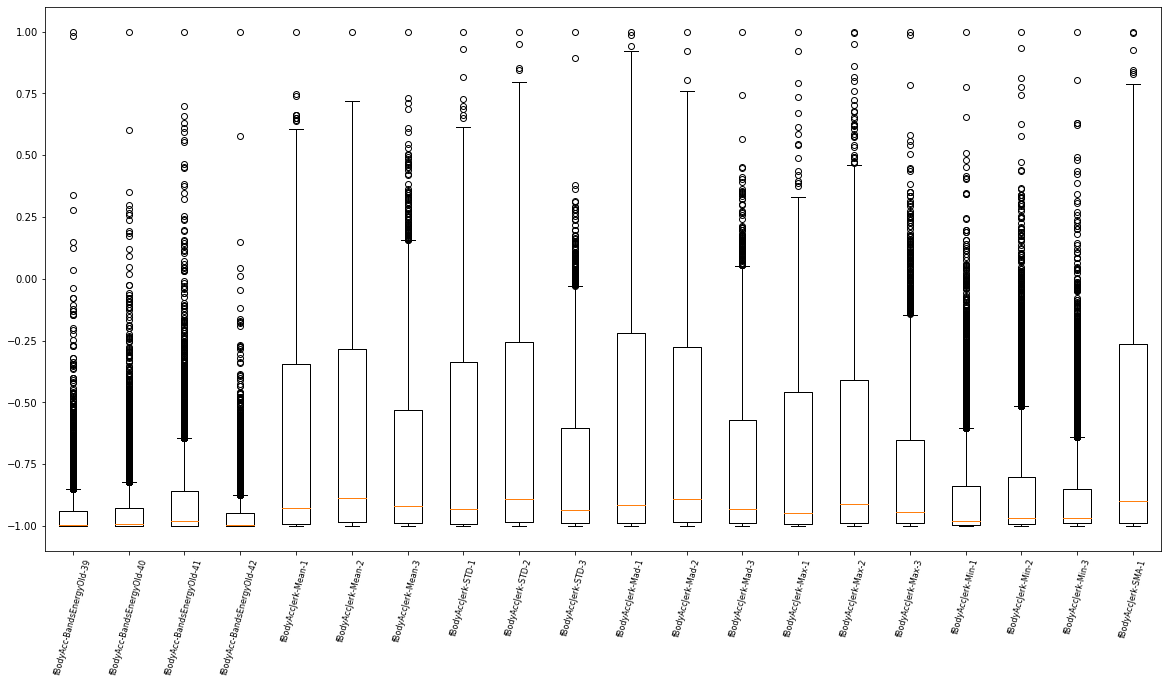

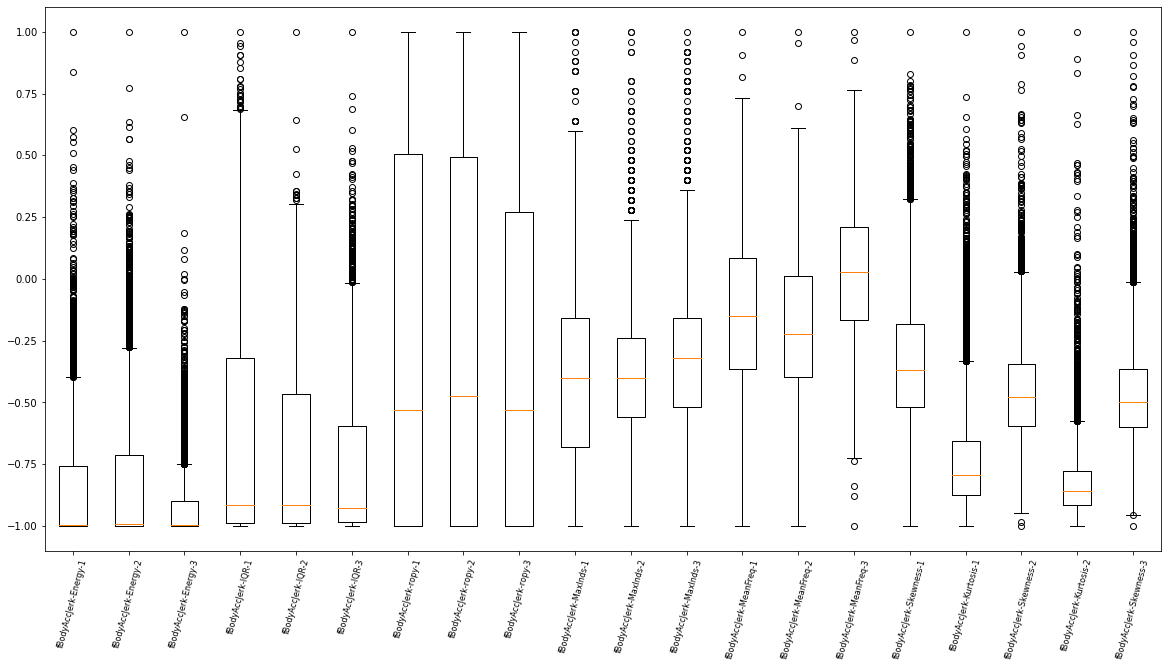

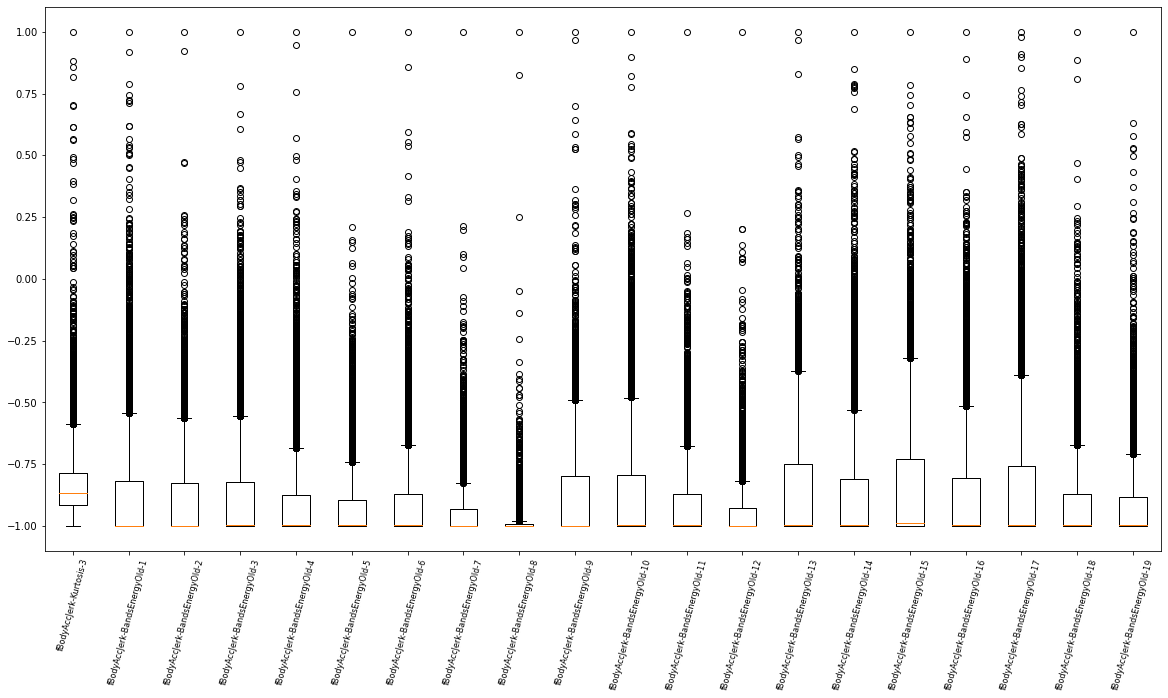

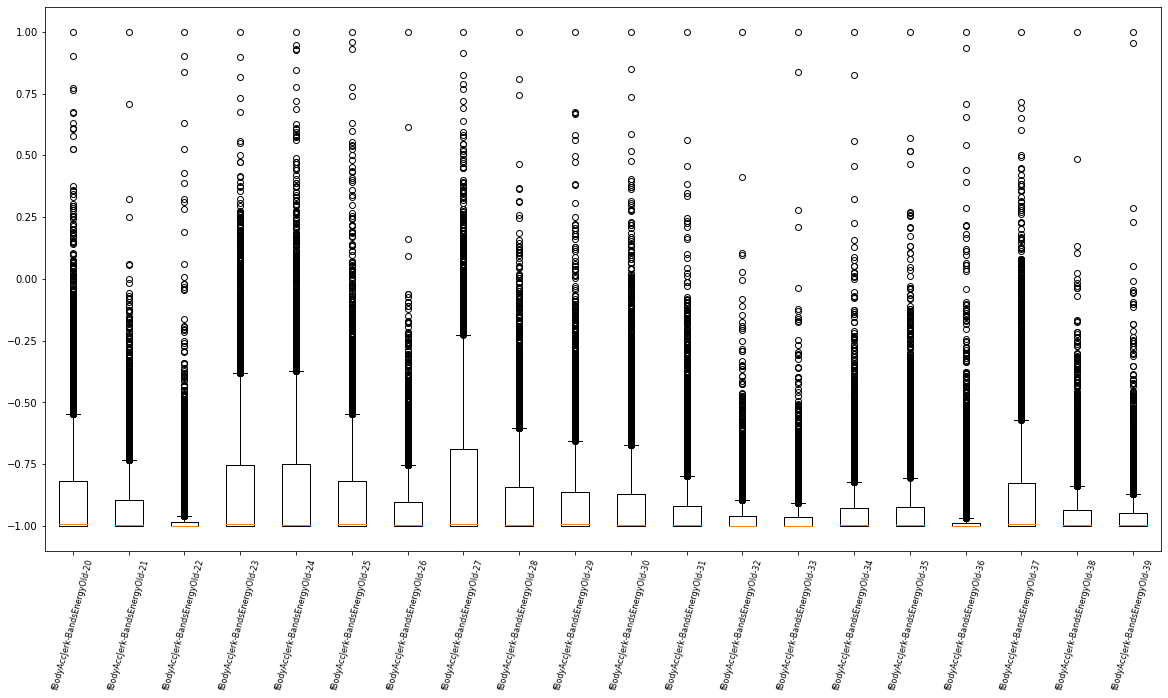

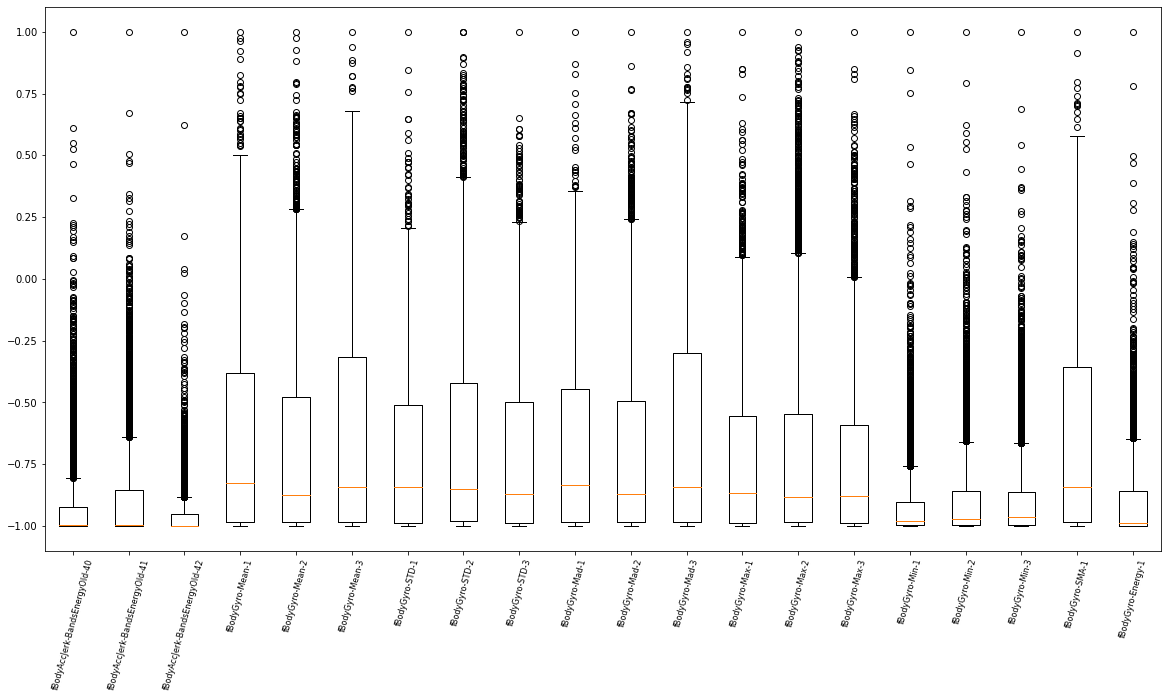

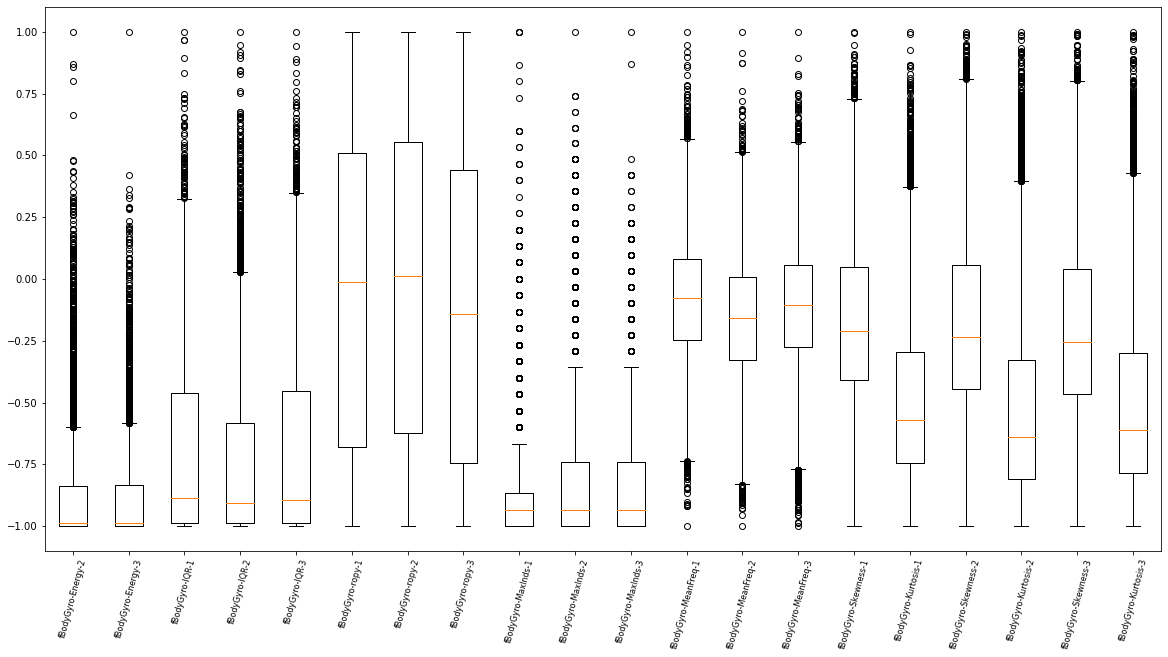

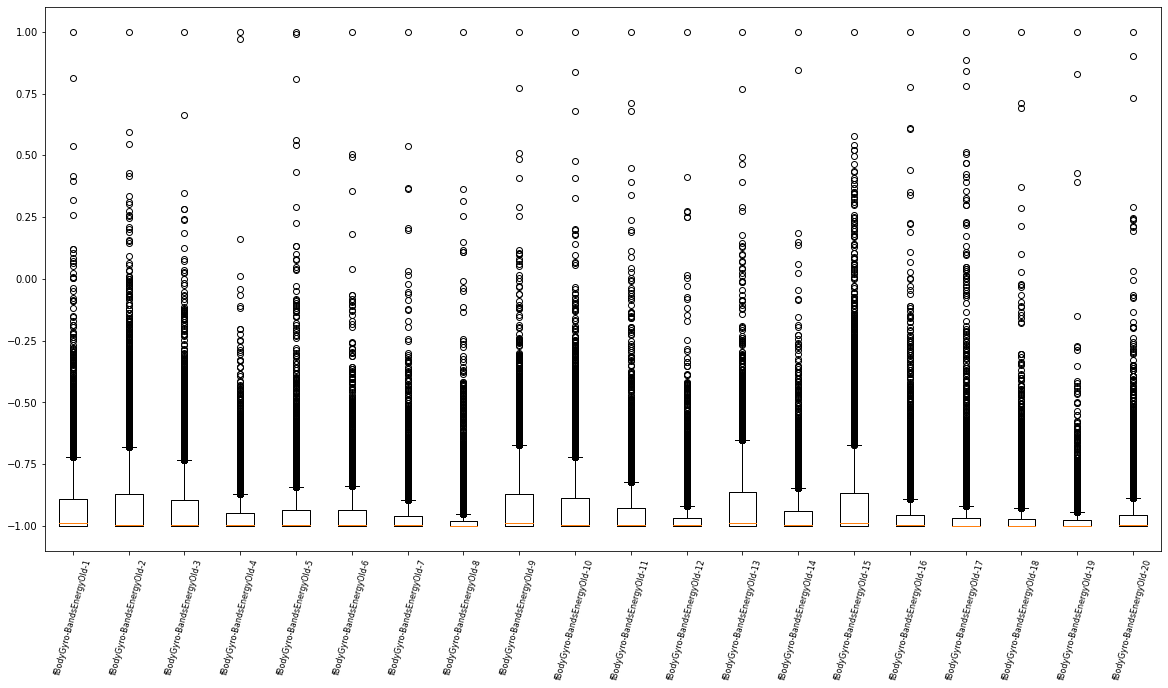

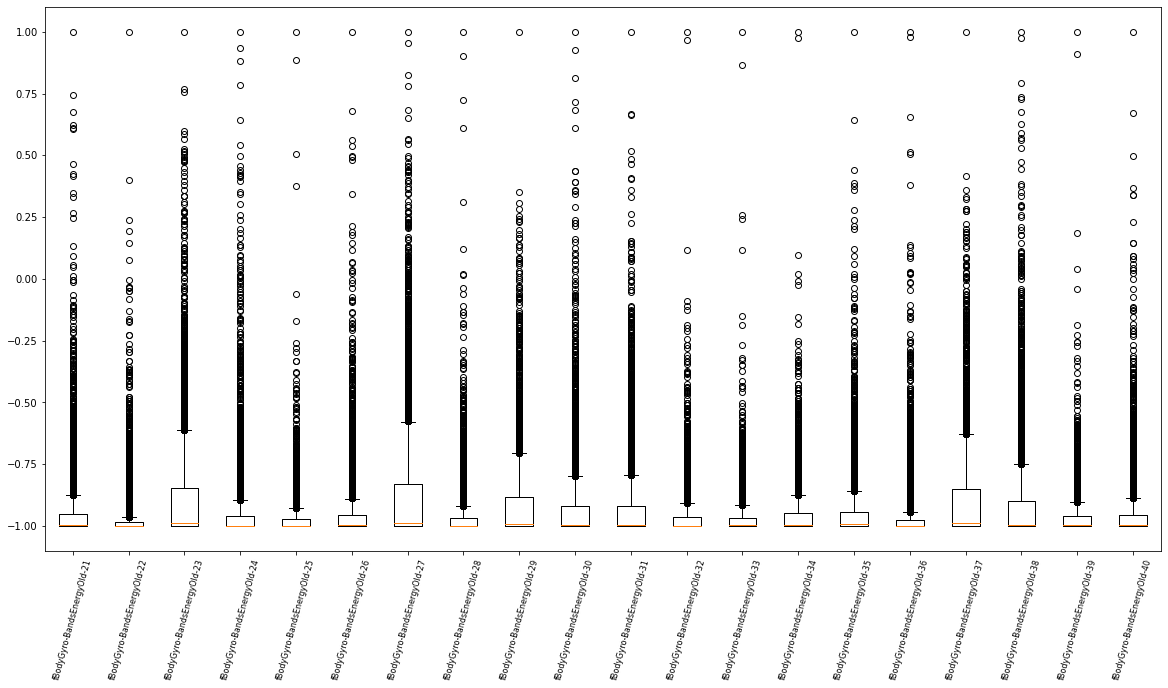

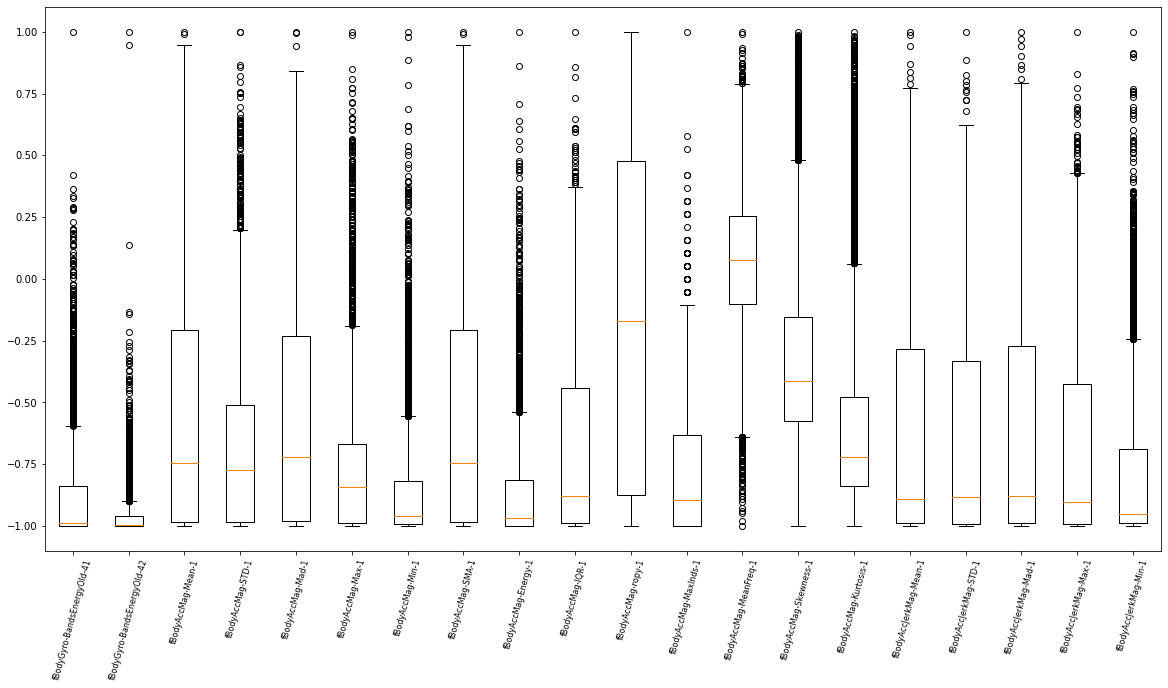

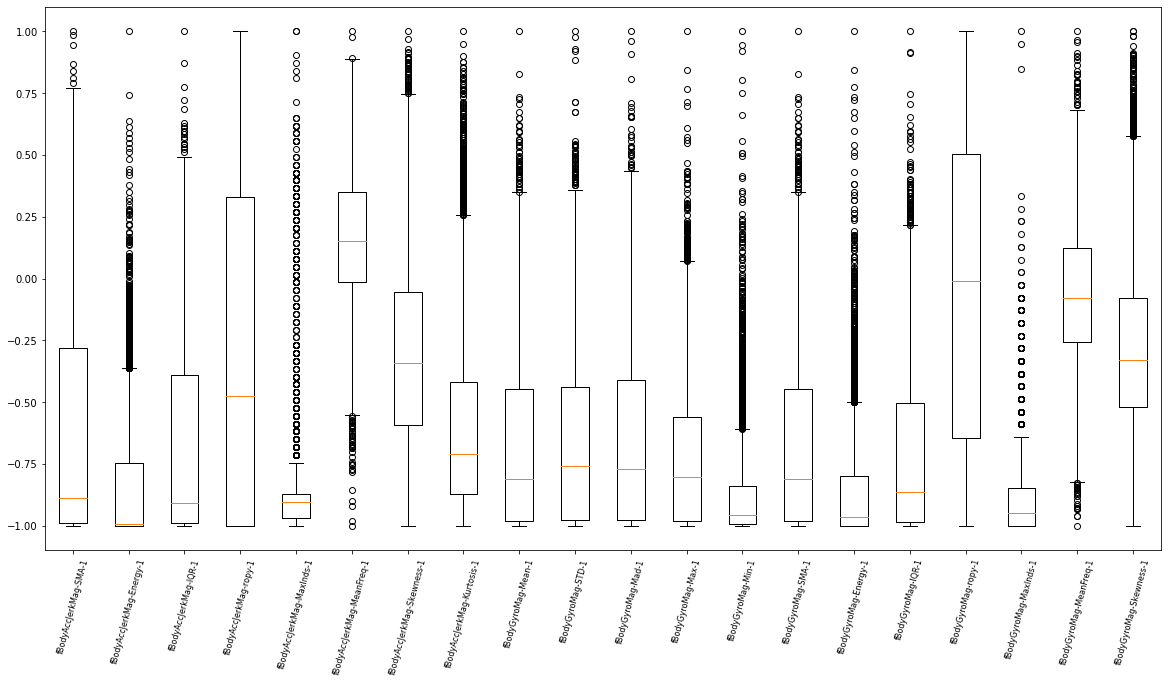

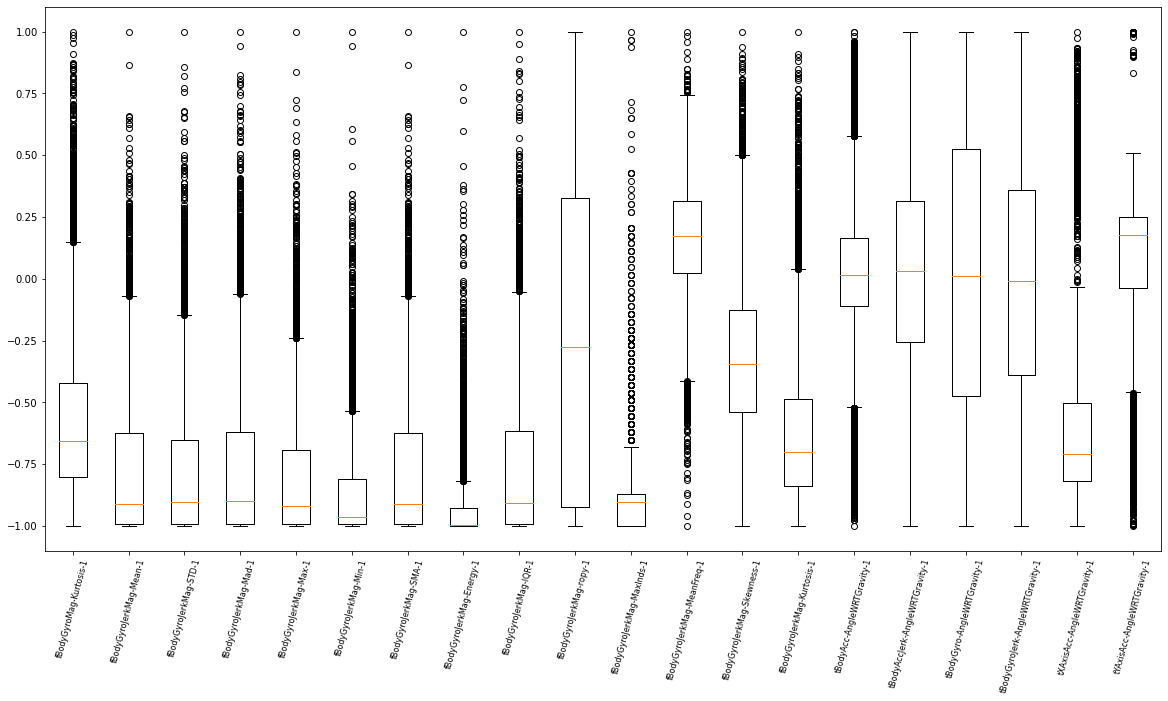

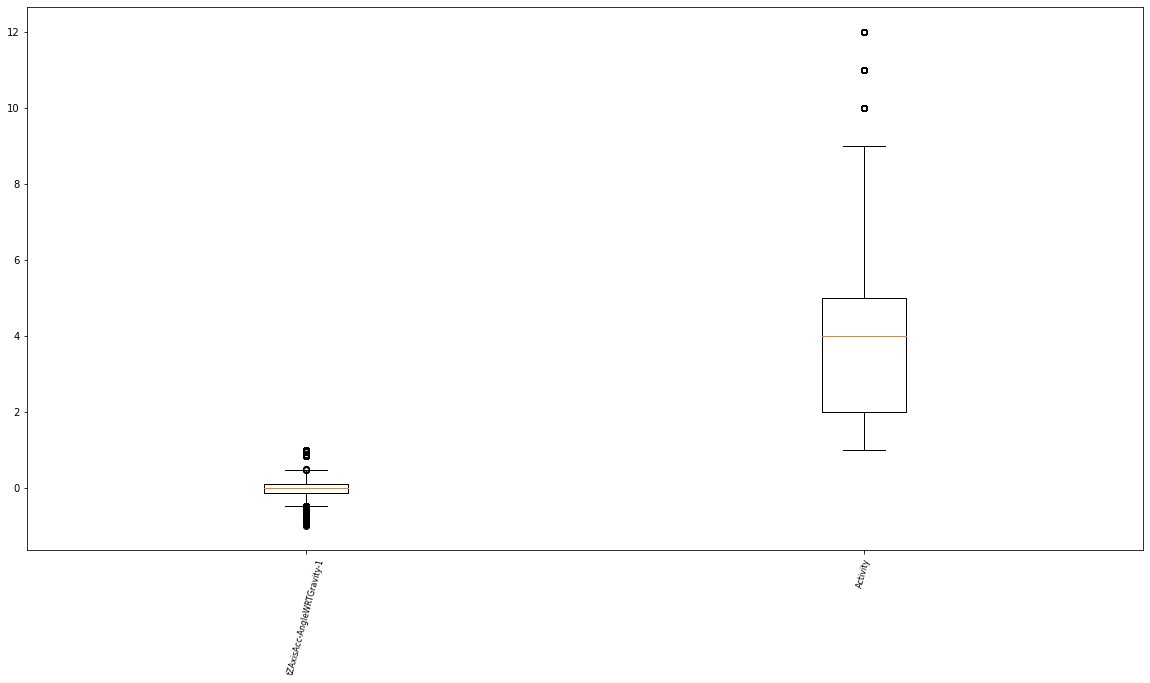

In [5]:
labels = []
data = []

def plot():
    fig1, ax1 = plt.subplots(figsize=(20,10))
    ax1.boxplot(data)
    ax1.set_xticklabels(labels, rotation=75, fontsize=8)
    plt.show()

for columnName, columnData in dcopy.iteritems():
    labels.append(columnName)
    data.append(columnData)
    if len(labels) >= 20:
        plot()
        labels = []
        data = []

if len(labels) > 0:
    plot()

del labels
del data

## Scatter plot

In [24]:
# Pre-Process data

tsne_data = X.copy()
label = y.copy()

# Scale data so it has mean = 0, std = 1
scl = StandardScaler()
# and scale every entry to [0,1] range
tsne_data = scl.fit_transform(tsne_data)
# so that the sparse data is centered

# Reduce dimensions (speed up)
# uses SVD (Singular Value Decomposition)
# to linear dimensionality reduction (projection)
# requires not sparsed data
pca = PCA(n_components=0.9, random_state=3)
tsne_data = pca.fit_transform(tsne_data)

# Transform data
# t-distributed stochastic neighbor embedding
# nonlinear dimensionality reduction to high dim data
# for visulation on low dim spaces
tsne = TSNE(random_state=42, n_jobs=-1)
tsne_transformed = tsne.fit_transform(tsne_data)


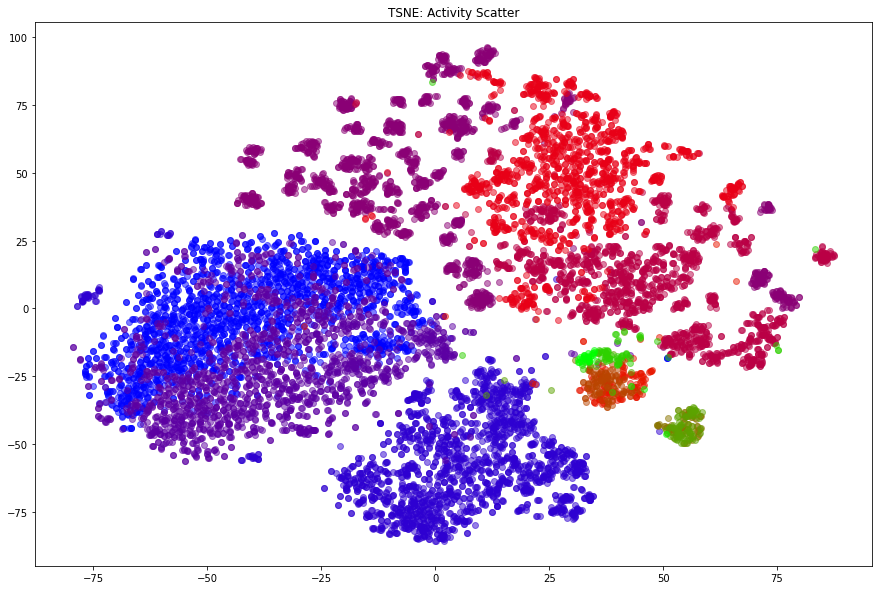

In [25]:
## Plot Activities

# Create subplots
plt.subplots(figsize=(15,10))

# Get colors
n = label.unique().shape[0]
colormap = get_cmap('brg')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each activity
for i, group in enumerate(label.value_counts().index):
    # Mask to separate sets
    mask = (label==group).values
    # ax[0]
    plt.scatter(
        x=tsne_transformed[mask][:,0],
        y=tsne_transformed[mask][:,1],
        c=colors[i],
        alpha=0.5,
        label=group
    )
plt.title('TSNE: Activity Scatter')
plt.show()

## Correlation

In [ ]:
corr = dcopy.corr(method='spearman')
corr_target = abs(corr['Activity'])
filtered = corr_target[corr_target > 0.8]
print(filtered)

## VIF

In [5]:
## Using describe matrices

patsy_df = dcopy.copy()
# add Intercept column (all 1's column)
patsy_df = add_constant(patsy_df)
my_formula = patsy.ModelDesc(
    [patsy.Term([patsy.LookupFactor('Activity')]), patsy.Term([patsy.LookupFactor('const')])],
    [patsy.Term([patsy.LookupFactor(c)]) for c in patsy_df.drop(columns=['Activity', 'const']).columns]
)
reg_y, reg_X = patsy.dmatrices(my_formula, data=patsy_df, return_type='dataframe')

vif = pd.DataFrame()
vif['VIF Factor'] = [
    variance_inflation_factor(reg_X.values, i) for i in range(reg_X.shape[1])
]
vif["features"] = reg_X.columns

vif_filtered = vif.sort_values('VIF Factor',ascending=False, inplace=False, na_position="first", ignore_index=True)
vif_filtered = vif_filtered[vif_filtered['VIF Factor'] >= 10]
vif_filtered = vif_filtered.round(1)

/home/gabriel/.pyenv/versions/anaconda3-2020.07/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


KeyError: "None of [Index(['fBodyAcc-SMA-1', 'tBodyAccMag-Mean-1', 'tBodyAccMag-Energy-1',\n       'tBodyAccMag-SMA-1', 'tBodyAccMag-Min-1', 'tBodyAccMag-Max-1',\n       'tBodyAccMag-Mad-1', 'tBodyAccMag-STD-1',\n       'fBodyAccJerk-BandsEnergyOld-6', 'fBodyAccJerk-BandsEnergyOld-14',\n       ...\n       'tBodyAcc-ropy-2', 'tBodyGyroJerk-ARCoeff-8', 'tBodyAccJerk-ARCoeff-8',\n       'tGravityAcc-SMA-1', 'tBodyAcc-Mean-1', 'tBodyGyroJerk-ARCoeff-12',\n       'fBodyAccJerkMag-MeanFreq-1', 'fBodyAcc-MeanFreq-1',\n       'fBodyGyroJerkMag-MeanFreq-1', 'fBodyAcc-MeanFreq-3'],\n      dtype='object', length=490)] are in the [columns]"

In [10]:
features = vif_filtered['features'].values.tolist()
print(features)

['fBodyAcc-SMA-1', 'tBodyAccMag-Mean-1', 'tBodyAccMag-Energy-1', 'tBodyAccMag-SMA-1', 'tBodyAccMag-Min-1', 'tBodyAccMag-Max-1', 'tBodyAccMag-Mad-1', 'tBodyAccMag-STD-1', 'fBodyAccJerk-BandsEnergyOld-6', 'fBodyAccJerk-BandsEnergyOld-14', 'fBodyAccJerk-BandsEnergyOld-7', 'fBodyAccJerk-BandsEnergyOld-8', 'fBodyAccJerk-BandsEnergyOld-9', 'fBodyAccJerk-BandsEnergyOld-10', 'fBodyAccJerk-BandsEnergyOld-11', 'fBodyAccJerk-BandsEnergyOld-12', 'tBodyAccMag-IQR-1', 'tBodyAccMag-ropy-1', 'tBodyAccMag-ARCoeff-1', 'tBodyAccMag-ARCoeff-2', 'tBodyAccMag-ARCoeff-3', 'tBodyAccMag-ARCoeff-4', 'tGravityAccMag-Mean-1', 'tGravityAccMag-STD-1', 'tGravityAccMag-Mad-1', 'tGravityAccMag-Max-1', 'tGravityAccMag-Min-1', 'tGravityAccMag-SMA-1', 'tGravityAccMag-Energy-1', 'tGravityAccMag-IQR-1', 'tGravityAccMag-ropy-1', 'tGravityAccMag-ARCoeff-1', 'tGravityAccMag-ARCoeff-2', 'fBodyAccJerk-BandsEnergyOld-13', 'fBodyAccJerk-BandsEnergyOld-15', 'fBodyGyro-Mean-3', 'fBodyAccJerk-BandsEnergyOld-36', 'fBodyAccJerk-BandsE

In [6]:
## without describe matrices

no_patsy = dcopy.copy()
X = add_constant(no_patsy)

vif = pd.DataFrame()
vif['VIF Factor'] = [
    variance_inflation_factor(X.values, i) for i in range(X.shape[1])
]

vif["features"] = X.columns

vif_filtered2 = vif.sort_values('VIF Factor',ascending=False, inplace=False, na_position="first", ignore_index=True)
vif_filtered2 = vif_filtered2[vif_filtered2['VIF Factor'] >= 5]
vif_filtered2 = vif_filtered2.round(1)


/home/gabriel/.pyenv/versions/anaconda3-2020.07/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/.pyenv/versions/anaconda3-2020.07/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
